In [338]:
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline 

In [339]:
%pwd

'C:\\Users\\kiran\\DataScience'

In [340]:
my_path = '/Users/kiran/DataScience'

In [341]:
%pwd

'C:\\Users\\kiran\\DataScience'

In [342]:
my_df = pd.read_csv(f'{my_path}/Titanic_full.csv')

In [343]:
print(my_df.shape)

(1309, 12)


In [344]:
my_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [345]:
print(my_df.shape)

(1309, 12)


In [346]:
#Splitting the data by writing a fucntion

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]

mydf_train_valid,mydf_test = mydf_splitter(my_df,1100)

print(mydf_train_valid.shape,mydf_test.shape)

(1100, 12) (209, 12)


In [347]:
print(len(mydf_train_valid))

1100


In [348]:
print(mydf_train_valid.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            219
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          849
Embarked         2
dtype: int64


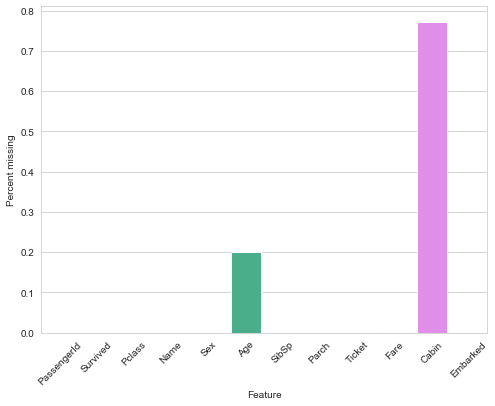

In [349]:
null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace=True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize=(8,6))
plt.xticks(rotation = 45)
sns.barplot(x="Feature",y="Percent missing",data=null_vals)

In [350]:
mydf_train_valid_2 = mydf_train_valid.drop("Cabin",axis = 1)
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(2)

(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [351]:
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Name         1100 non-null   object 
 4   Sex          1100 non-null   object 
 5   Age          881 non-null    float64
 6   SibSp        1100 non-null   int64  
 7   Parch        1100 non-null   int64  
 8   Ticket       1100 non-null   object 
 9   Fare         1099 non-null   float64
 10  Embarked     1098 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [352]:
def str_to_cat(my_df):
    for p,q in my_df.items():
        if is_string_dtype(q):
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [353]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Name         1100 non-null   category
 4   Sex          1100 non-null   category
 5   Age          881 non-null    float64 
 6   SibSp        1100 non-null   int64   
 7   Parch        1100 non-null   int64   
 8   Ticket       1100 non-null   category
 9   Fare         1099 non-null   float64 
 10  Embarked     1098 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [354]:
#Check category mapping of Embarked and Sex columns

print(mydf_train_valid_3.Embarked.cat.categories)
print(mydf_train_valid_3.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


In [355]:
#categorical missing values function
def mydf_to_nums(my_df,feature,null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes+1;

def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table 

def mydf_preprocessor(my_df,null_table):
    if null_table is None:
        null_table = dict()
    for p,q in my_df.items():
        null_table = mydf_imputer(my_df,q,p,null_table)
    for p,q in my_df.items():
        mydf_to_nums(my_df,q,p)
    my_df = pd.get_dummies(my_df,dummy_na = True)
    res = [my_df, null_table]
    return res;

In [356]:
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)

In [357]:
mydf_train_valid_4.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False
2,3,1,3,442,1,26.0,0,0,799,7.9250,3,False,False


In [358]:
my_table

{'Age': 28.0, 'Fare': 14.4583}

In [359]:
Y = mydf_train_valid_4["Survived"]
X = mydf_train_valid_4.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1100, 12) (1100,)


In [360]:
#Scale the continuous value so seperate continuous and categorical value
X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con = X.drop(X_cat,axis = 1)
print(X_cat.shape,X_con.shape)

(1100, 10) (1100, 2)


In [361]:
#Scale the data
scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [362]:
#Store the scalar variable and categorical value for test data
df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [363]:
X_train,X_valid = mydf_splitter(X_full,900)
Y_train,Y_valid = mydf_splitter(Y,900)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)

(900, 12) (200, 12) (900,) (200,)


In [364]:
#Build the classifier model
my_knn_model = KNeighborsClassifier(n_neighbors=5,weights='uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)

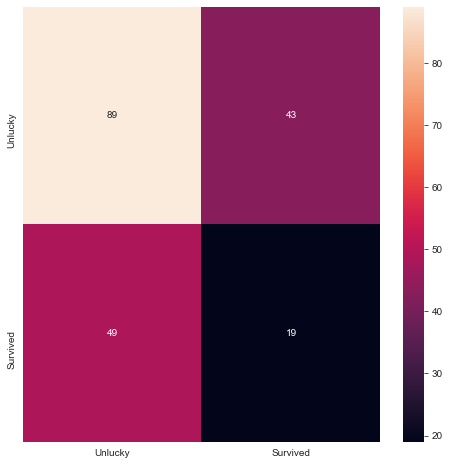

In [365]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize=(8,8))
sns.heatmap(my_knn_df,xticklabels=["Unlucky","Survived"],
           yticklabels=["Unlucky","Survived"],annot=True)


In [366]:
print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))


0.54 -0.0474697036788388 0.29230769230769227


# Hyper Parameter Tuning  Using RandomizedSearchCV


In [367]:
from sklearn.model_selection import  RandomizedSearchCV
import numpy as np
k_range = np.arange(1,31)
weights = ["uniform","distance"]
p = [1,2]
metric=['minkowski','euclidean','manhattan']
leaf_size = list(range(1,50))
metric_params = dict
metric_params = None
n_jobs = None
param_grid = dict(n_neighbors = k_range, weights = weights,p=p,metric = metric,leaf_size=leaf_size)
knn = KNeighborsClassifier()
randomized = RandomizedSearchCV(knn, param_grid,scoring = "accuracy", cv = 10, n_iter = 10)

In [368]:
randomized.fit(X_train,Y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'metric': ['minkowski', 'euclidean',
       

In [369]:
#Finding the best estimator
randomized.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=1,
                     weights='uniform')

In [370]:
randomized.cv_results_

{'mean_fit_time': array([0.00494826, 0.00312777, 0.00191612, 0.00201755, 0.00276833,
        0.00404913, 0.00394239, 0.00390875, 0.00364189, 0.00598671]),
 'std_fit_time': array([0.00211569, 0.00625554, 0.00482862, 0.00473336, 0.00383624,
        0.00495726, 0.00409817, 0.0037234 , 0.00414747, 0.00414351]),
 'mean_score_time': array([0.00513389, 0.00197825, 0.00247836, 0.00570555, 0.00066299,
        0.00254335, 0.00212383, 0.00232937, 0.0014365 , 0.00658062]),
 'std_score_time': array([0.00308516, 0.00471402, 0.00500993, 0.00691733, 0.00198898,
        0.00389844, 0.00313562, 0.00305592, 0.0021151 , 0.00443541]),
 'param_weights': masked_array(data=['uniform', 'distance', 'distance', 'uniform',
                    'distance', 'uniform', 'distance', 'uniform',
                    'distance', 'uniform'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_p': masked_arr

In [371]:
randomized.best_params_

{'weights': 'uniform',
 'p': 1,
 'n_neighbors': 30,
 'metric': 'manhattan',
 'leaf_size': 20}

In [372]:
randomized.best_score_

0.6555555555555557

In [373]:
Y_pred = randomized.predict(X_valid)
accuracy = accuracy_score(Y_valid,Y_pred)
print(accuracy)

0.585


In [423]:
#Build the classifier model
my_knn_model=KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=26, p=1,
                     weights='uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)


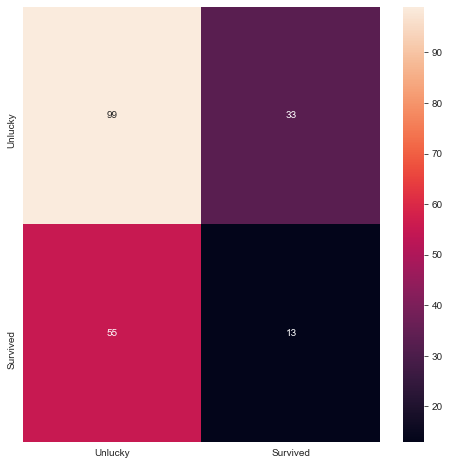

In [424]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize=(8,8))
sns.heatmap(my_knn_df,xticklabels=["Unlucky","Survived"],
           yticklabels=["Unlucky","Survived"],annot=True)



In [376]:

print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))


0.575 -0.08055835276914584 0.17475728155339806


After using RandomizedSearchCV and tuned to parameters to find optimal parameters We got an accuracy score of 57.5%

In [377]:
from sklearn.metrics import accuracy_score

num_neighs = list()
accuracy_list = list()


for neighbor in range(1,30):
    my_knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=neighbor, p=2,
                     weights='uniform')
    my_knn_model.fit(X_train,Y_train)
    Y_pred = my_knn_model.predict(X_valid)
    accuracy = accuracy_score(Y_valid,Y_pred)
    num_neighs.append(neighbor)
    accuracy_list.append(accuracy)

In [378]:
eval_df = pd.DataFrame({"Num of neighbors":num_neighs,"Valid accuracy Score":accuracy_list})
eval_df

,Num of neighbors,Valid accuracy Score
0,1,0.500
1,2,0.580
2,3,0.495
3,4,0.565
4,5,0.540
5,6,0.560
6,7,0.530
7,8,0.570
8,9,0.555
9,10,0.595


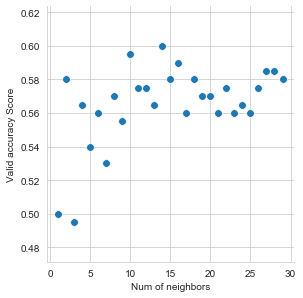

In [379]:
sns.set_style("whitegrid")
sns.pairplot(eval_df,x_vars="Num of neighbors",
            y_vars = "Valid accuracy Score",plot_kws={'s':60},height=4.0)


In [380]:
#For K=27

knn_model_fin = KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')
knn_model_fin.fit(X_full,Y)



#!mkdir knn_model
#knn_model_name = f'{my_path}/knn_model/knn_model_final.sav'
#joblib.dump(knn_model_fin,knn_model_name)

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')

In [381]:
#!mkdir knn_model
knn_model_name = f'{my_path}/knn_model/knn_model_final.sav'
joblib.dump(knn_model_fin,knn_model_name)


['/Users/kiran/DataScience/knn_model/knn_model_final.sav']

In [382]:
!ls knn_model

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [383]:
knn_model_loaded = joblib.load(knn_model_name)

In [384]:
#Evaluating test set accuracy with the trained model
mydf_test1 = mydf_test.drop("Cabin",axis = 1)
print(mydf_test1.shape)
mydf_test1.head(3)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,S


In [385]:
mydf_test2 = str_to_cat(mydf_test1)
mydf_test2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [386]:
#Check for the Embarked column
mydf_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [387]:
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,
                                        null_table = my_table)
print(mydf_test3.shape)
mydf_test3.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
1100,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1101,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
1102,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [388]:
my_table1

{'Age': 28.0, 'Fare': 14.4583}

In [389]:
Y_t = mydf_test3["Survived"]
X_t = mydf_test3.drop(["Survived"],axis = 1)

print(X_t.shape,Y_t.shape)

(209, 12) (209,)


In [390]:
X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con_t = X_t.drop(X_cat_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(209, 10) (209, 2)


In [391]:
X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape)
X_con_sct.head(2)

(209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [392]:
print(X_cat_t.shape,X_con_sct.shape)

(209, 10) (209, 2)


In [393]:
X_cat_t.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
1100,1101,3,47,2,0,0,106,3,False,False
1101,1102,3,6,2,0,0,146,3,False,False
1102,1103,3,62,2,0,0,187,3,True,False
1103,1104,2,45,2,0,0,179,3,False,False
1104,1105,2,91,1,1,0,38,3,False,False


In [394]:
#Re-index before merging
X_cat_t.reset_index(inplace = True,drop = False)

In [395]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

C:\Users\kiran\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1101,3,47,2,0,0,106,3,False,False
1,1102,3,6,2,0,0,146,3,False,False


In [396]:
#Merge the two sets of columns
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(3)

(209, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944
2,1103,3,62,2,0,0,187,3,True,False,-0.111921,-0.506060


In [397]:
#Now we are ready to test it out. Let's load the saved model first.
kNN_loaded = joblib.load(f'{my_path}/knn_model/knn_model_final.sav')

In [398]:
#Testing...
Y_test_pred = kNN_loaded.predict(X_test_I)


In [399]:
print(accuracy_score(Y_t,Y_test_pred),
      matthews_corrcoef(Y_t,Y_test_pred),f1_score(Y_t,Y_test_pred))

0.5645933014354066 0.0 0.0


C:\Users\kiran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


After hypertuning the features using RandomizedSearchCV and found best features to train the model.The training set after hypertuning got an accuracy score of 0.64 and validation set got an accuracy score of 55%.Using this hypertuned model when test set was used to predict a model the ouptut was 56%.

Answer for Question 2

1)One of the biggest issues with K-NN is to choose the optimal number of neighbors to be consider while classifying the new data entry.
2)k-NN doesn’t perform well on imbalanced data. If we consider two classes, A and B, and the majority of the training data is labeled as A, then the model will ultimately give a lot of preference to A. This might result in getting the less common class B wrongly classified.
3)K-NN algorithm is very sensitive to outliers as it simply chose the neighbors based on distance criteria.
4)The time complexity of algorithm is O(n2)

In [400]:
'''Write out full train_valid and test dataframes for later use
in module III'''
X_full["Survived"] = Y
X_test_I["Survived"] = Y_t

print(X_full.shape)
print(X_test_I.shape)

(1100, 13)
(209, 13)


In [401]:
#Overfit Underfit ROC and AUC


In [402]:
print(X_train.shape)
print(X_test_I.shape)


(900, 12)
(209, 13)


In [403]:
X_train.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957
2,3,3,442,1,0,0,799,3,False,False,-0.266246,-0.488977
3,4,1,354,1,1,0,56,3,False,False,0.428217,0.392967
4,5,3,19,2,0,0,565,3,False,False,0.428217,-0.486537


In [404]:
X_test_I.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare,Survived
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547,NaN
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944,NaN
2,1103,3,62,2,0,0,187,3,True,False,-0.111921,-0.506060,NaN
3,1104,2,45,2,0,0,179,3,False,False,-0.960709,0.791233,NaN
4,1105,2,91,1,1,0,38,3,False,False,2.357281,-0.136102,NaN


In [405]:
#Create X and Y for train
#X_train = X_train.drop('Survived',axis = 1)
#Y_train = X_train['Survived']
print(X_train.shape,Y_train.shape)

(900, 12) (900,)


In [406]:
#Create X and Y for test set

X_test = X_test_I.drop('Survived',axis = 1)
Y_test = Y_t
print(X_test.shape,Y_test.shape)

(209, 12) (209,)


In [407]:
Y_test

1100    1
1101    0
1102    1
1103    0
1104    0
       ..
1304    0
1305    1
1306    0
1307    1
1308    1
Name: Survived, Length: 209, dtype: int64

In [408]:
# Train AND predict on the TRAINING set with k = 27

knn_model_I = KNeighborsClassifier(n_neighbors = 27)
knn_model_I.fit(X_train, Y_train)
Y_pred = knn_model_I.predict(X_train)

In [409]:
#Evaluate training set accuracy
accuracy_score(Y_train,Y_pred)

0.6733333333333333

In [410]:
#Evaluate test set accuracy
Y_pred_test = knn_model_I.predict(X_test)
print(Y_pred_test)

[1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1
 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1
 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0
 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1]


In [411]:
#Evaluate test set accuracy
accuracy_score(Y_test,Y_pred_test)

0.5454545454545454

In [412]:
'''Make a confusion matrix for the K = 27 model based test set predictions.
Make a pandas dataframe out of it so that we can use seaborn to 
plot it easily'''

c_mat = confusion_matrix(Y_test,Y_pred_test)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.head(2)

,0,1
0,45,73
1,22,69


In [413]:
c_mat_df.columns = ["Did not Survive","Survived"]
c_mat_df.index = ["Did not Survive","Survived"]
c_mat_df = c_mat_df.T
c_mat_df

,Did not Survive,Survived
Did not Survive,45,22
Survived,73,69


Text(52.0, 0.5, 'Predicted')

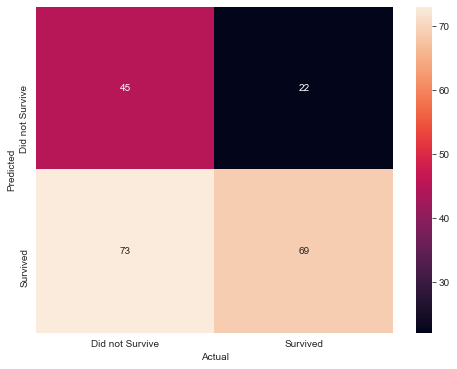

In [414]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [415]:
#true positives
tp = 45
#true negatives
tn = 69
#false positives
fp = 22
#false negatives
fn = 73


In [416]:
#Recall = tp/tp+fn
#Precision = tp/(tp+fp)

recall = 45/(45+5)
precision = 45/(45+22)
print(recall,precision)

0.9 0.6716417910447762


In [417]:
#F1 score = 2*(precision*recall)/(precision+recall)
f_score=(2*recall*precision)/(recall+precision)
f_score

0.7692307692307693

In [418]:
#Displaying the classification report
from sklearn.metrics import classification_report,roc_curve,roc_auc_score
scores = classification_report(Y_test,Y_pred_test)
print(scores)

              precision    recall  f1-score   support

           0       0.67      0.38      0.49       118
           1       0.49      0.76      0.59        91

    accuracy                           0.55       209
   macro avg       0.58      0.57      0.54       209
weighted avg       0.59      0.55      0.53       209



In [419]:
#Roc and AUC 
rec, fall_out, thresholds = roc_curve(Y_test,Y_pred_test)

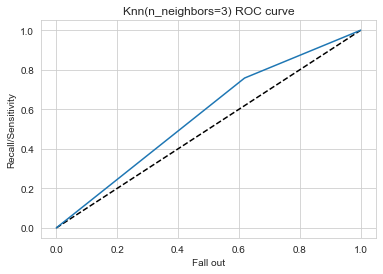

In [420]:
plt.plot([0,1],[0,1],'k--')
plt.plot(rec,fall_out, label='Knn')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Knn(n_neighbors=3) ROC curve')
plt.show()

In [421]:
#Area under ROC curve
roc_auc_score(Y_test,Y_pred_test)

0.569798845222574

Answer for Question 2

1)One of the biggest issues with K-NN is to choose the optimal number of neighbors to be consider while classifying the new data entry. 2)k-NN doesn’t perform well on imbalanced data. If we consider two classes, A and B, and the majority of the training data is labeled as A, then the model will ultimately give a lot of preference to A. This might result in getting the less common class B wrongly classified. 3)K-NN algorithm is very sensitive to outliers as it simply chose the neighbors based on distance criteria. 4)The time complexity of algorithm is O(n2)